In [1]:
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
# based on Zhang, L. implementation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

kappa = 0.49254 # Mean Reversion Speed
theta = 0.05749 # Long Run Variance
sigma = 0.29549 # Volatility of Variance
rho = 0.08996 # Correlation
v0 = 0.15833 # Initial Variance (I use Implied Volatility from BSM instead)
T = 0.085274 # Time to maturity
s0 = 5342.2 # Spot Price
K = 5350 # Strike Price

N = 50 # Nº of simulations
dt = 1/32 # Timestep granularity (related to the nº of steps being generated)

vega=(4*kappa*theta/(sigma*sigma))
K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
K3=dt*(1-rho*rho)/2
ss=K2+K3/2
yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
sh=ss*np.exp(-kappa*dt)/yita
S=np.ones(N)*s0
Ntime=int(T/dt)
for i in range (0,Ntime):
    v=np.ones(N)*v0
    Zs=np.random.randn(1,N)
    lamb=v*yita
    W=np.random.noncentral_chisquare(vega,lamb)
    v2=W*np.exp(-kappa*dt)/yita
    K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
    S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
    vars()['payoff'+str(i)] = np.maximum(K-S,0) #for calls it's = np.maximum(S-K,0)

<IPython.core.display.Javascript object>


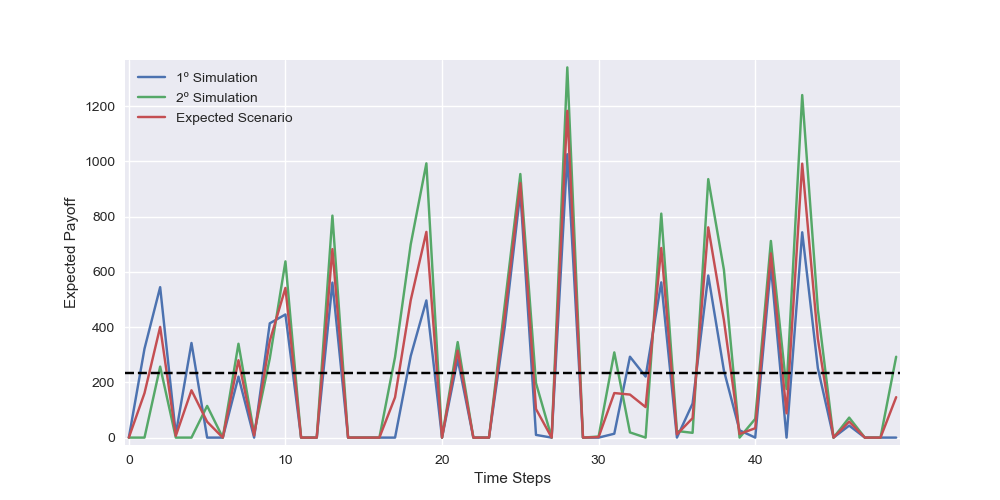

(expected) put price = 234.91


In [2]:
Sim1 = pd.Series(payoff0[0])
Sim2 = pd.Series(payoff1[0])

Expected = (Sim1+Sim2)/2

plt.figure(figsize=(10,5))
plt.plot(Sim1,label='1º Simulation')
plt.plot(Sim2,label='2º Simulation')
plt.plot(Expected,label='Expected Scenario')
plt.xlabel('Time Steps')
plt.ylabel('Expected Payoff')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=np.mean(Expected), xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('(expected) put price =',round(np.mean(Expected),2)) #but we don't really know what price is gonna be

In [3]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

def Heston_Calls(series):
    kappa = series['kappa']
    theta = series['theta']
    sigma = series['sigma']
    rho = series['rho']
    v0 = series['Cv0']
    T = series['T']
    s0 = series['s0']
    K = series['K']
    N = 10000
    dt = 1/32
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        v=np.ones(N)*v0
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
    payoff=np.maximum(S-K,0)
    return np.mean(payoff)

def Heston_Puts(series):
    kappa = series['kappa']
    theta = series['theta']
    sigma = series['sigma']
    rho = series['rho']
    v0 = series['Pv0']
    T = series['T']
    s0 = series['s0']
    K = series['K']
    N = 10000
    dt = 1/32
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        v=np.ones(N)*v0
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
    payoff=np.maximum(K-S,0)
    return np.mean(payoff)

db = pd.read_hdf("optiondata.h5")
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [4]:
HTest = pd.DataFrame({'T': db['Expiration'],'Cv0': db['CallImpVol']**2, 'Now': db['Now'],
                     's0': db['Spot'],'Pv0': db['PutImpVol']**2,'Put': db['PutMid'],
                     'K': db['Strike'],'Call': db['CallMid'],'Maturity': db['Maturity']})

HTest[HTest['Cv0'] < 0.001] = 0
HTest[HTest['Pv0'] < 0.001] = 0
HTest = HTest.loc[(HTest!=0).any(1)]
HTest = HTest.reset_index().drop('index',axis=1)

HTest['Moneyness'] = abs(HTest['K']/HTest['s0'])
HTest['theta'] = 0.49254
HTest['kappa'] = 0.05749
HTest['sigma'] = 0.29549
HTest['rho'] = 0.08996

In [5]:
HTest['Heston Call'] = round(HTest.apply(Heston_Calls, axis=1),2)
HTest['CError'] = HTest['Heston Call']/HTest['Call']-1
abs(HTest['CError']).describe()

count    429.000000
mean       0.053438
std        0.080146
min        0.000158
25%        0.009161
50%        0.022549
75%        0.057241
max        0.508571
Name: CError, dtype: float64

In [6]:
HTest['Heston Put'] = round(HTest.apply(Heston_Puts, axis=1),2)
HTest['PError'] = HTest['Heston Put']/HTest['Put']-1
abs(HTest['PError']).describe()

count    429.000000
mean       0.023436
std        0.031159
min        0.000060
25%        0.006403
50%        0.013427
75%        0.026079
max        0.185734
Name: PError, dtype: float64

In [7]:
HTest.groupby('Maturity')['CError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,-0.213652,0.134496,-0.508571,-0.316935,-0.194444,-0.110477,-0.025532
2018-06-15 17:30:00,62.0,0.116029,0.073648,-0.031579,0.062084,0.103165,0.152814,0.326316
2018-09-21 17:30:00,105.0,0.010924,0.033864,-0.148571,-0.005180,0.007707,0.018206,0.170149
2018-12-21 17:30:00,125.0,0.018867,0.028890,-0.083784,0.002990,0.013398,0.029417,0.111236
2019-03-15 17:30:00,98.0,0.017914,0.017552,-0.022773,0.006738,0.016030,0.027815,0.064330


In [8]:
HTest.groupby('Maturity')['PError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,-0.105704,0.041818,-0.185734,-0.133268,-0.097820,-0.070480,-0.046035
2018-06-15 17:30:00,62.0,-0.010237,0.013613,-0.044412,-0.018369,-0.009511,-0.000416,0.024879
2018-09-21 17:30:00,105.0,-0.020298,0.015563,-0.064453,-0.029164,-0.018715,-0.009294,0.009967
2018-12-21 17:30:00,125.0,-0.011384,0.014664,-0.056451,-0.019060,-0.008950,-0.003452,0.025485
2019-03-15 17:30:00,98.0,0.003669,0.013817,-0.024212,-0.004895,0.004360,0.012159,0.060857


<IPython.core.display.Javascript object>


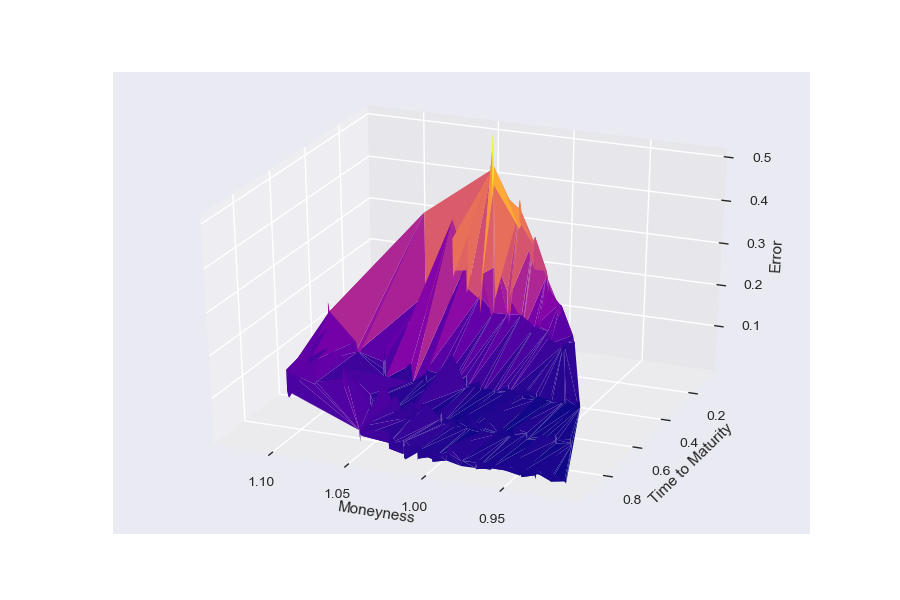

In [9]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['CError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()

<IPython.core.display.Javascript object>


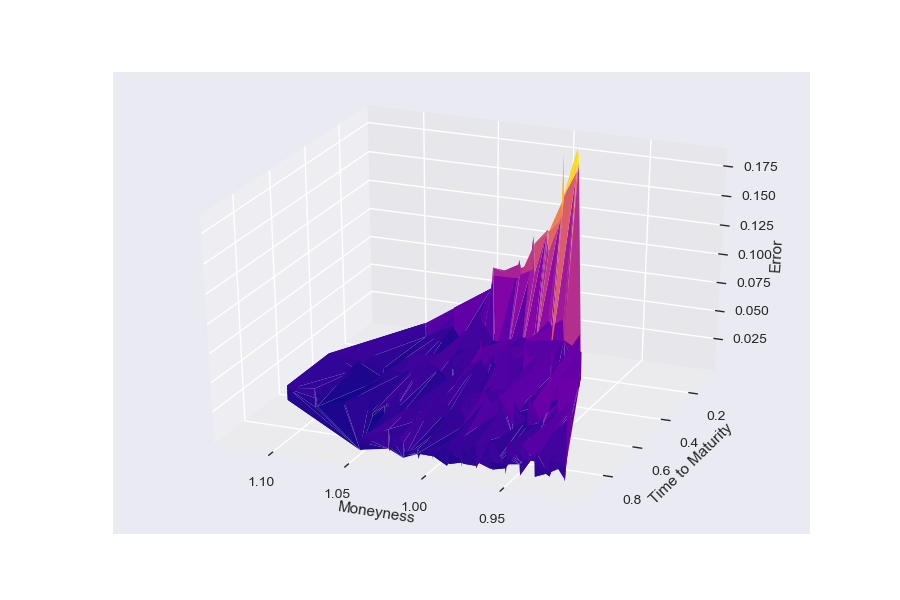

In [10]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['PError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()